## DATA 558: Homework 2

Geoffrey Li

April 19, 2019

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Exercise 1

### Exercise 1, part i: Loading and processing data

In [2]:
# Load the data
hitters = pd.read_csv(
    'https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv',
    sep=',', header=0)
hitters.dropna(inplace=True)
hitters.reset_index(drop=True, inplace=True)

In [3]:
# Create our X matrix with the predictors and y vector with the response
X = hitters.drop('Salary', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = hitters.Salary

In [4]:
# Divide the data into training and test sets. By default, 25% goes into the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# Standardize the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [6]:
# Don't need to add intercept since we already standardized data
# X_train = preprocessing.add_dummy_feature(X_train)
# X_test = preprocessing.add_dummy_feature(X_test)

In [7]:
# We need to convert the y's to arrays before standardizing them
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Standardize y's
scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))
y_train = scaler.transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

### Exercise 1, part ii: Creating functions for gradient descent

In [8]:
# Computes gradient given x, y, beta, and lambda
def computegrad(x, y, beta, lamb):
    return (-2/len(x)) * (x.T @ (y - x@beta)) + (2*lamb)*beta

In [9]:
# Performs gradient descent given initial Beta vector, step size, lambda, and max # of iterations
def graddescent(beta_init, step_size, lamb, max_iter):
    
    beta_values = list()
    beta_values.append(beta_init)
    
    for t in range(1, max_iter):
        beta_values.append(
            beta_values[t-1] - 
            step_size*computegrad(X_train, y_train, beta_values[t-1], lamb)
        )
    
    return beta_values

In [10]:
# Computes Objective Value given x, y, beta, and lambda
def computeobjvalue(x, y, b, lamb):
    return 1/len(x)*np.sum((y - x@b)**2)+lamb*np.sum(b**2)

### Exercise 1, part iii: Run Gradient Descent (first trial with constant step size = 0.05)

In [11]:
# Run the gradient descent
# for step size = 0.05
beta_zeros = np.zeros(X_train.shape[1]).reshape(-1, 1)
step_size = 0.05
max_t = 1000
lamb = 0.05

beta_results = graddescent(beta_zeros, step_size, lamb, max_t)

# Create array of Objective Values at each iteration
obj_value_results = list(map(lambda bt: computeobjvalue(X_train, y_train, bt, lamb), beta_results))

In [12]:
# Final iterate of gradient descent algorithm, beta_T
beta_T = beta_results[len(beta_results)-1]

print('Beta_T')
print(beta_T.round(4))

Beta_T
[[-0.231 ]
 [ 0.2868]
 [ 0.0747]
 [ 0.0122]
 [ 0.0526]
 [ 0.1939]
 [-0.0849]
 [ 0.0324]
 [ 0.3052]
 [-0.0562]
 [ 0.2906]
 [ 0.0848]
 [-0.2018]
 [ 0.1322]
 [ 0.0549]
 [-0.0858]
 [ 0.0409]
 [-0.1264]
 [-0.0055]]


In [18]:
# Objective value for beta_T
print('F(Beta_T)')
print(computeobjvalue(X_train, y_train, beta_T, lamb))

F(Beta_T)
0.5573240582930424


#### Plot of Objective Values (y-axis) vs. Iteration Number (x-axis)

First gradient descent trial with step size = 0.05, max iterations = 1000, lambda = 0.05

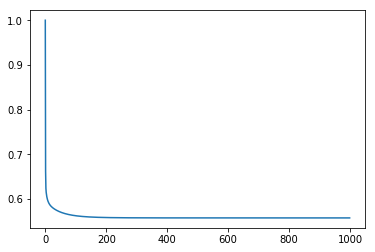

In [14]:
plt.plot(range(0, len(obj_value_results)),obj_value_results)

As seen in the plot above, we approach the minimum optimal objective value ($F(\beta_T$)) at around ~200 iterations. Iterations after that do not significantly improve the optimization.

### Exercise 1, part iv: Using sklearn.Ridge for $\beta^*$

In [15]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=lamb*len(y_train), solver='lsqr')
ridge.fit(X_train, y_train)

Ridge(alpha=9.850000000000001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='lsqr', tol=0.001)

In [16]:
beta_star = ridge.coef_.reshape(-1,1)
print('Beta_*')
print(beta_star.round(4))

Beta_*
[[-0.2346]
 [ 0.2866]
 [ 0.0752]
 [ 0.0154]
 [ 0.0517]
 [ 0.1936]
 [-0.0837]
 [ 0.0403]
 [ 0.3034]
 [-0.0553]
 [ 0.2839]
 [ 0.0872]
 [-0.2052]
 [ 0.1341]
 [ 0.0541]
 [-0.0831]
 [ 0.0405]
 [-0.1272]
 [-0.0056]]


In [19]:
print('F(Beta_*)')
print(computeobjvalue(X_train, y_train, beta_star, lamb))

F(Beta_*)
0.5573458151920914


In [20]:
# Trying to compute the objective value from the objective function from Ridge documentation
# np.sum((y_train - X_train@beta_star)**2)+lamb*np.sum(beta_star**2)

#### Comparing $\beta_T$ with $\beta^*$ using relative error
Relative to $\beta^*$

In [21]:
print('Vector Difference of Beta')
print((beta_T - beta_star).round(4))

Vector Difference of Beta
[[ 0.0036]
 [ 0.0001]
 [-0.0005]
 [-0.0032]
 [ 0.0009]
 [ 0.0003]
 [-0.0012]
 [-0.0079]
 [ 0.0017]
 [-0.0009]
 [ 0.0068]
 [-0.0025]
 [ 0.0034]
 [-0.0019]
 [ 0.0008]
 [-0.0026]
 [ 0.0004]
 [ 0.0008]
 [ 0.0001]]


In [22]:
print('Relative Error of Beta')
print(np.sqrt(np.sum((beta_T - beta_star)**2))/np.sqrt(np.sum(beta_star**2)))

Relative Error of Beta
0.019011672600635337


In [23]:
print('Difference of Objective Value')
print(computeobjvalue(X_train, y_train, beta_T, lamb)-computeobjvalue(X_train, y_train, beta_star, lamb))

Difference of Objective Value
-2.17568990489303e-05


In [24]:
print('Relative Difference of Objective Value')
print((computeobjvalue(X_train, y_train, beta_T, lamb)-computeobjvalue(X_train, y_train, beta_star, lamb))/
      computeobjvalue(X_train, y_train, beta_star, lamb))

Relative Difference of Objective Value
-3.903662404181092e-05


As shown above, there are considerable differences between the $\beta_T$ we found using gradient descent and the $\beta^*$ we found using the Ridge function sklearn (as well as their corresponding objective values). I believe the differences are due to two main reasons:

1. We are solving different objective functions. If you look up the documentation for the sklearn.Ridge function, their objective function lacks the 1/n factor in front of the empirical risk term. I'm unsure if that form is able to be solved using gradient descent. I tried and wasn't able to get a reasonable answer.

2. Additionally, you can specify different solver functions using the Ridge function. I chose the 'lsqr' solver as I felt it was the closest approximation to our approach, but it's unclear if they use exactly the same gradient descent approach we do. My inclination is that it doesn't, so we are seeing different results.

### Exercise 1, part v: Running gradient descent with different step size values

In [23]:
# Run the gradient descent
# Trying different step sizes on log scale: [..., 0.0005, 0.005, 0.05, 0.5, 5, ...]
beta_zeros = np.zeros(X_train.shape[1]).reshape(-1, 1)
step_size_attempts = [5*10**i for i in range(-10,2)]
max_t = 1000
lamb = 0.05

obj_value_results_ss = list()
beta_T_ss = list()
beta_results_ss = list()

for i in range(0, len(step_size_attempts)):
    beta_results_ss = graddescent(beta_zeros, step_size_attempts[i], lamb, max_t)
    beta_T_ss.append(beta_results_ss[len(beta_results_ss)-1])
    obj_value_results_ss.append([step_size_attempts[i], computeobjvalue(X_train, y_train, beta_T_ss[i], lamb)])

/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in matmul
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in matmul
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# Outputs [step_size, value of objective function]
obj_value_results_ss

[[5e-10, 0.9999948294062458],
 [5e-09, 0.9999482972811333],
 [5e-08, 0.9994832945288697],
 [5e-07, 0.9948649678511244],
 [4.9999999999999996e-06, 0.951707882506658],
 [5e-05, 0.7184499397770052],
 [0.0005, 0.5933133205928035],
 [0.005, 0.5622254234162926],
 [0.05, 0.5573240582930424],
 [0.5, nan],
 [5, nan],
 [50, nan]]

As shown above, the optimal step size was in fact the first one we tried, 0.05. Step sizes any higher than that (on the log scale) will result in the gradient descent not converging properly.

Since the optimal step size was the same as what we used in part iii above, we won't compare the results again (please refer to part iv for the comparison with Ridge function Beta and objective value).

## Exercise 2

(a) Read in the dataset. The data can be downloaded from this url: http://www-bcf.usc.edu/~gareth/ISL/Auto.csv. When reading in the data use the option na values=’?’. Then drop all NaN values using dropna().

In [25]:
auto = pd.read_csv('./Auto.csv', na_values='?')
auto.dropna(inplace=True)
auto.reset_index(drop=True, inplace=True)

In [26]:
# The instructions don't say to change data types, but I would argue origin, year, and perhaps cylinders could
# be coded as categorical values.
auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

(b) Use the OLS function from the statsmodels package to perform a simple linear regression with mpg as the response and weight as the predictor. Be sure to include an intercept. Use the summary() attribute to print the results. Comment on the output. For example:

- (i) Is there a relationship between the predictor and the response?
- (ii) How strong is the relationship between the predictor and the response?
- (iii) Is the relationship between the predictor and the response positive or negative?

In [27]:
X = auto['weight']
X = sm.add_constant(X)
Y = auto['mpg']

model_2 = sm.OLS(Y,X)
results_2 = model_2.fit()
results_2.summary()

/anaconda3/envs/data558/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     878.8
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          6.02e-102
Time:                        20:57:20   Log-Likelihood:                -1130.0
No. Observations:                 392   AIC:                             2264.
Df Residuals:                     390   BIC:                             2272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.2165      0.799     57.867      0.000      44.646      47.787
weight        -0.0076      0.000    -29.645      0.000      -0.008      -0.007
==============================================================================
Omnibus:                       41.682   Durbin-Watson:                   0.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.039
Skew:                           0.727   Prob(JB):                     9.18e-14
Kurtosis:                       4.251   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# p-value for weight predictor
results_2.pvalues[1]

6.01529605143624e-102

- Judging from the p-value for the weight predictor, there appears to be a relationship between the predictor and the response, based on a significance threshold of 0.05.
- The relationship appears to be very strong, with a p-value on the order of $10^{-100}$.
- The relationship between weight and mpg appears to be negative, judging by the sign of the coefficient, showing that the mpg decreases by -0.0076 for every unit increase in weight.
- The model $R^2$ value is 69%, indicating a decent fit, but one that could be improved. This shows the amount of variation in the data explained by our model.

(c) Plot the response and the predictor using the plot fit function.

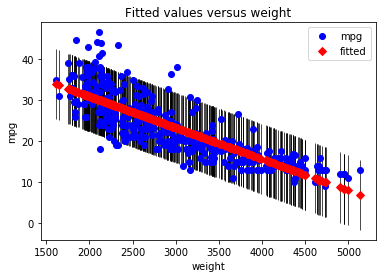

In [29]:
fig2_1, ax2_1 = plt.subplots()
fig2_1 = sm.graphics.plot_fit(results_2, "weight", ax=ax2_1)

(d) Plot the residuals vs. fitted values. Comment on any problems you see with the fit.

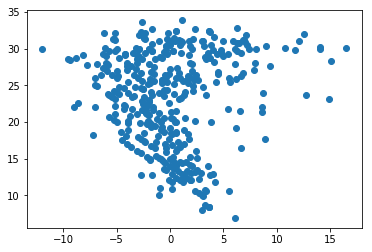

In [30]:
fig2_2, ax2_2 = plt.subplots()
fig2_2 = ax2_2.scatter(results_2.resid, results_2.fittedvalues)

The residuals vs fitted plot appears to show heteroscedasticity (violating assumption of equal variance) - there is more variability on the left side of the plot than right side.

## Exercise 3

(a) Produce a scatterplot matrix which includes all of the variables in the data set using pandas.plotting.scatter_matrix.

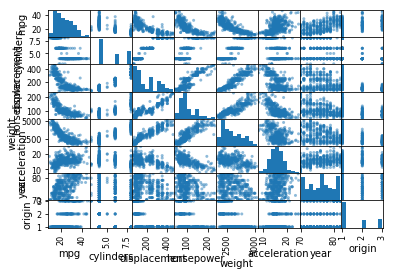

In [31]:
pd.plotting.scatter_matrix(auto);

(b) Compute the matrix of correlations between the variables using the corr() attribute in Pandas.

In [32]:
auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


(c) Use the OLS function from the statsmodels package to perform a multiple linear regression with mpg as the response and all other variables except name as the predictors. Be sure to include an intercept. Print the results. Comment on the output.

In [33]:
X = auto.iloc[:,1:-1]
X = sm.add_constant(X)
Y = auto['mpg']

model_3 = sm.OLS(Y,X)
results_3 = model_3.fit()
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          2.04e-139
Time:                        20:58:30   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707      0.000     -26.350      -8.087
cylinders       -0.4934      0.323     -1.526      0.128      -1.129       0.142
displacement     0.0199      0.008      2.647      0.008       0.005       0.035
horsepower      -0.0170      0.014     -1.230      0.220      -0.044       0.010
weight          -0.0065      0.001     -9.929      0.000      -0.008      -0.005
acceleration     0.0806      0.099      0.815      0.415      -0.114       0.275
year             0.7508      0.051     14.729      0.000       0.651       0.851
origin           1.4261      0.278      5.127      0.000       0.879       1.973
==============================================================================
Omnibus:                       31.906   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.100
Skew:                           0.529   Prob(JB):                     2.95e-12
Kurtosis:                       4.460   Cond. No.                     8.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Based on a significance threshold of 0.05, we see that there are a few correlations that appear to be significant:
    - displacement
    - weight
    - year
    - origin
        - NOTE: This should actually be coded as a categorical value since the integer differences between the values here don't make any intuitive sense.
- The coefficients of the significant variables show that there is a:
    - positive association with displacement, year, and origin
    - negative association with weight
- In particular, the positive association with year suggests fuel efficiency (mpg) is getting better over the years, most likely due to improving technology and government regulations.
- The $R^2$ value increased to 82%, from the 69% from the model with just weight as a predictor. Thus we can say this model explains a higher proportion of the total variation of the data.

(d) Plot the residuals vs. fitted values. Comment on any problems you see with the fit.

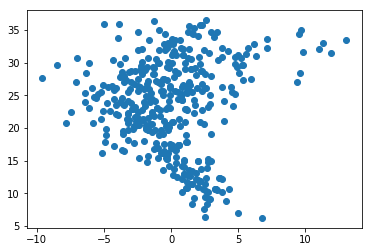

In [34]:
fig3_1, ax3_1 = plt.subplots()
fig3_1 = ax3_1.scatter(results_3.resid, results_3.fittedvalues)

Again, the residuals vs fitted plot appears to show heteroscedasticity (violating assumption of equal variance) - there is more variability on the left side of the plot than right side.

(e) 
Statsmodels allows you to fit models using R-style formulas. See http://www.statsmodels.org/dev/example_formulas.html. Use the * and : symbols to fit linear regression models with interaction effects. Do any interactions appear to be statistically significant?


In [35]:
model_3_2 = smf.ols(formula = 'mpg ~ displacement + weight + year * C(origin)', data=auto)
results_3_2 = model_3_2.fit()
results_3_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     265.9
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          5.36e-143
Time:                        20:58:47   Log-Likelihood:                -1015.0
No. Observations:                 392   AIC:                             2046.
Df Residuals:                     384   BIC:                             2078.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.1165      5.259     -0.973      0.331     -15.457       5.224
C(origin)[T.2]        -37.3539     10.256     -3.642      0.000     -57.519     -17.189
C(origin)[T.3]        -25.3217      9.441     -2.682      0.008     -43.884      -6.759
displacement            0.0048      0.005      0.955      0.340      -0.005       0.015
weight                 -0.0067      0.001    -12.060      0.000      -0.008      -0.006
year                    0.6152      0.066      9.302      0.000       0.485       0.745
year:C(origin)[T.2]     0.5187      0.134      3.865      0.000       0.255       0.783
year:C(origin)[T.3]     0.3564      0.121      2.937      0.004       0.118       0.595
==============================================================================
Omnibus:                       21.047   Durbin-Watson:                   1.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.426
Skew:                           0.357   Prob(JB):                     2.03e-08
Kurtosis:                       4.288   Cond. No.                     2.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Yes: if we treat origin as a categorical variable and interact it with year, we see that the coefficients for the interactions between year and origin are significant at the 0.05 level. This can be interpreted as there being different changes in the mpg per year increase for different car origins.

(f) Try a few different transformations of the variables, such as log(X), √X, X2 . Comment on your findings.

In [36]:
X = auto['weight']**2
X = sm.add_constant(X)
Y = auto['mpg']

model_3_3 = sm.OLS(Y,X)
results_3_3 = model_3_3.fit()
results_3_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     726.6
Date:                Fri, 19 Apr 2019   Prob (F-statistic):           4.11e-91
Time:                        20:58:55   Log-Likelihood:                -1155.0
No. Observations:                 392   AIC:                             2314.
Df Residuals:                     390   BIC:                             2322.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.4693      0.471     73.215      0.000      33.544      35.395
weight      -1.15e-06   4.27e-08    -26.956      0.000   -1.23e-06   -1.07e-06
==============================================================================
Omnibus:                       34.868   Durbin-Watson:                   0.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.576
Skew:                           0.701   Prob(JB):                     3.45e-10
Kurtosis:                       3.838   Cond. No.                     2.23e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This models uses mpg vs. weight^2. The association appears to be significant with a pos. coefficient of -1.15e-06 ((change in mpg per unit squared weight). 

In [37]:
X = auto['weight']**(0.5)
X = sm.add_constant(X)
Y = auto['mpg']

model_3_4 = sm.OLS(Y,X)
results_3_4 = model_3_4.fit()
results_3_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     935.4
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          1.20e-105
Time:                        20:59:03   Log-Likelihood:                -1121.4
No. Observations:                 392   AIC:                             2247.
Df Residuals:                     390   BIC:                             2255.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.6722      1.526     45.642      0.000      66.671      72.673
weight        -0.8556      0.028    -30.585      0.000      -0.911      -0.801
==============================================================================
Omnibus:                       46.768   Durbin-Watson:                   0.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.372
Skew:                           0.760   Prob(JB):                     1.17e-16
Kurtosis:                       4.478   Cond. No.                         389.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This models uses mpg vs. sqrt(weight). The association appears to be significant with a pos. coefficient of -0.8556 (change in mpg per unit sqrt(weight)).

## Exercise 4

This problem involves simple linear regression without an intercept.

(a) Recall that the coefficient estimate β for the linear regression of Y onto X without an intercept is given by (3.38). Under what circumstance is the coefficient estimate for the regression of X onto Y the same as the coefficient estimate for the regression of Y onto X?

They should be the same when the coefficient estimate is equal to 1, there are no other predictors, and there is no noise (perfect 1:1 relationship between Y and X).

(b) Generate an example in Python with n = 50 observations in which the coefficient estimate for the regression of X onto Y is different from the coefficient estimate for the regression of Y onto X.

In [38]:
x = list(range(1, 51))
y = [i**2 for i in x]

In [39]:
model_4_1a = sm.OLS(y,x)
results_4_1a = model_4_1a.fit()

results_4_1a.params[0]

37.871287128712865

In [40]:
model_4_1b = sm.OLS(x,y)
results_4_1b = model_4_1b.fit()

results_4_1b.params[0]

0.024755711288216027

As shown above, the estimates for the two models (Y on X, X on Y) are different.

(c) Generate an example in Python with n = 50 observations in which the coefficient estimate for the regression of X onto Y is the same as the coefficient estimate for the regression of Y onto X.

In [41]:
x = list(range(1, 51))
y = [i for i in x]

In [42]:
model_4_2a = sm.OLS(y,x)
results_4_2a = model_4_2a.fit()

results_4_2a.params[0]

1.0

In [43]:
model_4_2b = sm.OLS(x,y)
results_4_2b = model_4_2b.fit()

results_4_2b.params[0]

1.0

As shown above, the coefficient estimates for the two models (Y on X, X on Y) are exactly the same.